# Imports and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import skew, kurtosis

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# Load dataset
df = pd.read_csv("insurance_data.csv", parse_dates=['Policy Start Date'])


c:\Users\KyleFulcher\Documents\date_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1200000 non-null  int64         
 1   Age                   1181295 non-null  float64       
 2   Gender                1200000 non-null  object        
 3   Annual Income         1155051 non-null  float64       
 4   Marital Status        1181471 non-null  object        
 5   Number of Dependents  1090328 non-null  float64       
 6   Education Level       1200000 non-null  object        
 7   Occupation            841925 non-null   object        
 8   Health Score          1125924 non-null  float64       
 9   Location              1200000 non-null  object        
 10  Policy Type           1200000 non-null  object        
 11  Previous Claims       835971 non-null   float64       
 12  Vehicle Age           1199994 non-null  fl

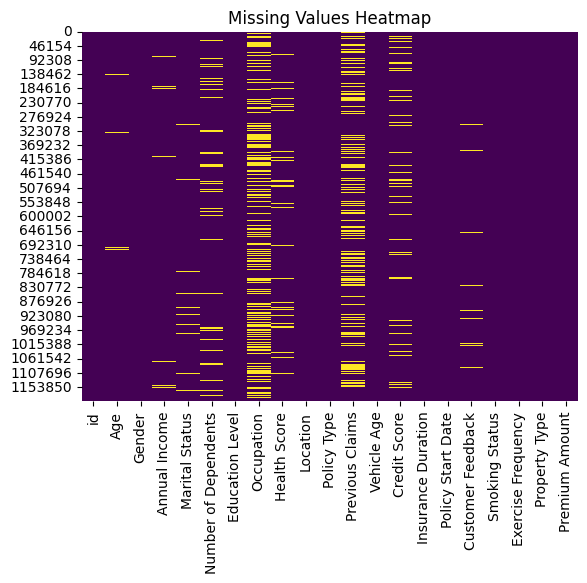

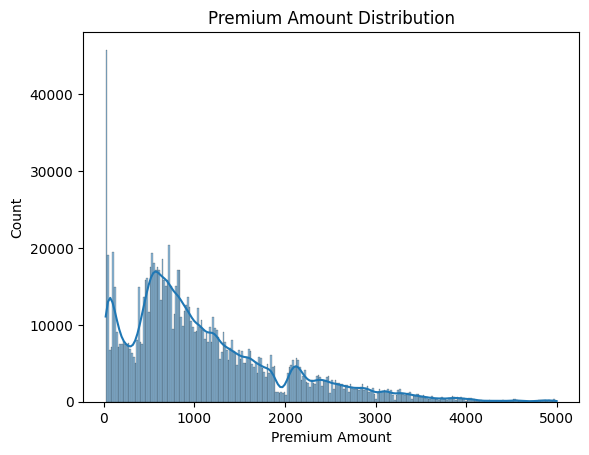

In [6]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.head())

# visual check of missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# target distribution
sns.histplot(df['Premium Amount'], kde=True)
plt.title("Premium Amount Distribution")
plt.show()

# Preprocessing

In [7]:
# drop ID and date for now
df.drop(['id', 'Policy Start Date'], axis=1, inplace=True)

# separate features and target
X = df.drop('Premium Amount', axis=1)
y = df['Premium Amount']

# identify column types
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# define preprocessing for numeric and categorical data
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


# Feature Engineering

In [ ]:
# age buckets
X['AgeGroup'] = pd.cut(X['Age'], bins=[0, 25, 40, 60, 100], labels=['Young', 'Adult', 'MiddleAge', 'Senior'])

# income per dependent
X['IncomePerDependent'] = X['Annual Income'] / (X['Number of Dependents'] + 1)

# is Urban
X['IsUrban'] = X['Location'].apply(lambda x: 1 if x == 'Urban' else 0)

# add new features to column categories
cat_cols += ['AgeGroup']
num_cols += ['IncomePerDependent', 'IsUrban']


# Train-Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Pipeline and Training
#### Note: This takes a significantly long amount of time to execute.

In [ ]:
# define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "MAE": mean_absolute_error(y_val, preds),
        "R2": r2_score(y_val, preds)
    }

    print(f"{name} Results:")
    print(f"  RMSE: {results[name]['RMSE']:.2f}")
    print(f"  MAE: {results[name]['MAE']:.2f}")
    print(f"  R^2: {results[name]['R2']:.4f}")
    print()


#### The below cell is the output of the above, used to speed up the development process.

In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0)
}


results = {
    "Linear Regression": {
        "RMSE": 863.31,
        "MAE": 667.27,
        "R2": 0.0027
    },
    "Ridge Regression": {
        "RMSE": 863.31,
        "MAE": 667.27,
        "R2": 0.0027
    },
    "Lasso Regression": {
        "RMSE": 863.29,
        "MAE": 667.29,
        "R2": 0.0027
    },
    "Random Forest": {
        "RMSE": 856.55,
        "MAE": 660.88,
        "R2": 0.0182
    },
    "Gradient Boosting": {
        "RMSE": 853.55,
        "MAE": 657.17,
        "R2": 0.0251
    },
    "XGBoost": {
        "RMSE": 847.53,
        "MAE": 645.41,
        "R2": 0.0388
    }
}

# Stacking
#### Note: This takes a significantly long amount of time to execute.

In [ ]:
# define base models
base_models = [
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42))
]

# define the final estimator (meta-model)
final_estimator = xgb.XGBRegressor(random_state=42, verbosity=0)

# create the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=True  # Pass original features to the meta-model
)

# create pipeline with preprocessing and stacking
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stacking_regressor)
])

# train stacking pipeline
stacking_pipeline.fit(X_train, y_train)

# evaluate stacking model
y_pred_stacking = stacking_pipeline.predict(X_val)
rmse_stacking = np.sqrt(mean_squared_error(y_val, y_pred_stacking))
mae_stacking = mean_absolute_error(y_val, y_pred_stacking)
r2_stacking = r2_score(y_val, y_pred_stacking)

print("Stacking Model Results:")
print(f"  RMSE: {rmse_stacking:.2f}")
print(f"  MAE: {mae_stacking:.2f}")
print(f"  R^2: {r2_stacking:.4f}")

#### Results from above to save computational time.

In [ ]:
#Stacking Model Results:

# RMSE: 846.93
# MAE: 642.84
# R²: 0.0401

# Actual vs Predicted

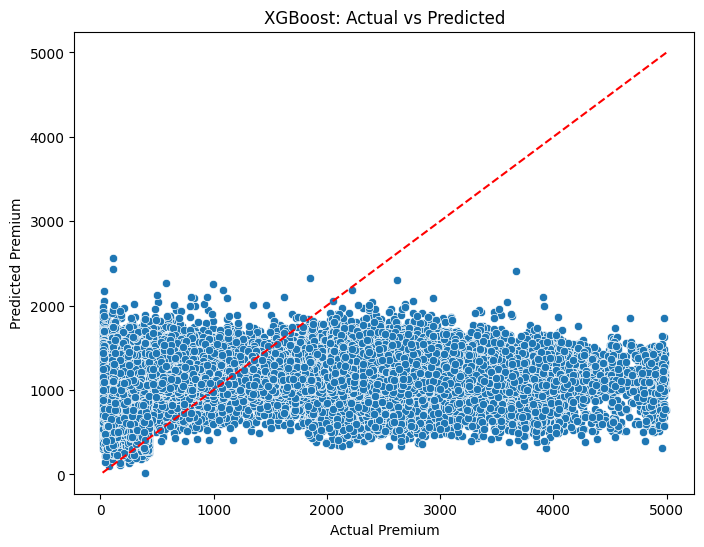

In [7]:
best_model_name = min(results, key=lambda k: results[k]['RMSE'])

# re-train best model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_val)

# scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Premium")
plt.ylabel("Predicted Premium")
plt.title(f"{best_model_name}: Actual vs Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

# XGBoost Deep Dive

## Residual Analysis for XGBoost

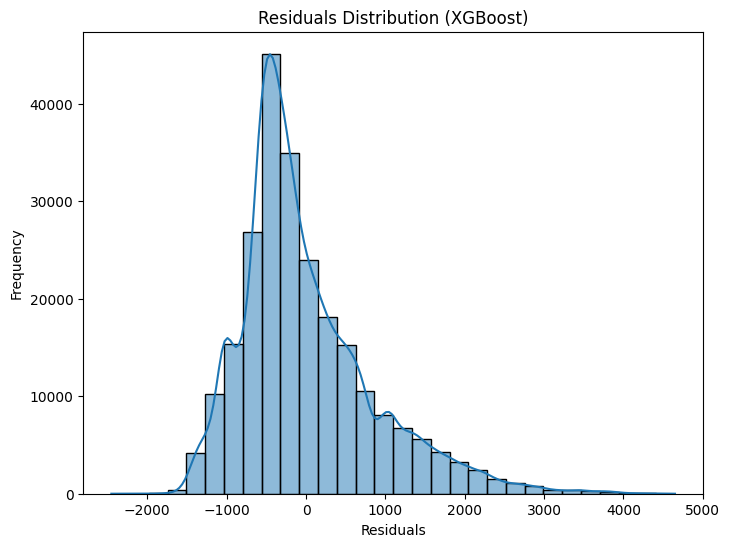

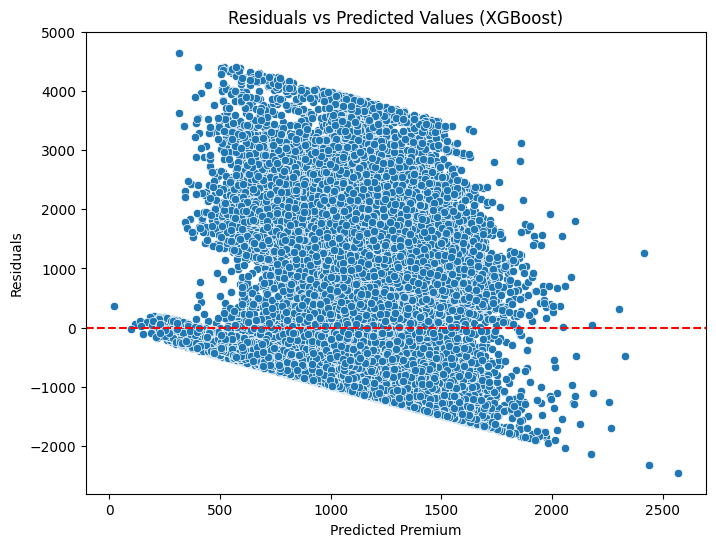

In [8]:
# get predictions from the XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models["XGBoost"])
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)

# calculate residuals
residuals = y_val - y_pred_xgb

# plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution (XGBoost)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# scatter plot: Residuals vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_xgb, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (XGBoost)")
plt.xlabel("Predicted Premium")
plt.ylabel("Residuals")
plt.show()

## Residual Analysis Summary for XGBoost

In [9]:
# summary statistics for residuals
residuals_mean = residuals.mean()
residuals_std = residuals.std()
residuals_min = residuals.min()
residuals_max = residuals.max()

print("Residuals Summary:")
print(f"  Mean: {residuals_mean:.2f}")
print(f"  Standard Deviation: {residuals_std:.2f}")
print(f"  Min: {residuals_min:.2f}")
print(f"  Max: {residuals_max:.2f}")

# skewness and kurtosis
residuals_skewness = skew(residuals)
residuals_kurtosis = kurtosis(residuals)

print(f"  Skewness: {residuals_skewness:.2f} (indicates symmetry)")
print(f"  Kurtosis: {residuals_kurtosis:.2f} (indicates tail heaviness)")

# correlation between residuals and predicted values
correlation = np.corrcoef(y_pred_xgb, residuals)[0, 1]
print(f"  Correlation between residuals and predicted values: {correlation:.2f} (should be close to 0)")

# identify outliers (residuals beyond 3 standard deviations)
outliers = residuals[np.abs(residuals) > 3 * residuals_std]
print(f"  Number of outliers: {len(outliers)}")

Residuals Summary:
  Mean: -0.04
  Standard Deviation: 847.53
  Min: -2453.75
  Max: 4648.70
  Skewness: 1.21 (indicates symmetry)
  Kurtosis: 1.82 (indicates tail heaviness)
  Correlation between residuals and predicted values: -0.01 (should be close to 0)
  Number of outliers: 3092


In [10]:
print(X_val.dtypes)
print(X_val.isnull().sum())
print(y_val.isnull().sum())

Age                      float64
Gender                    object
Annual Income            float64
Marital Status            object
Number of Dependents     float64
Education Level           object
Occupation                object
Health Score             float64
Location                  object
Policy Type               object
Previous Claims          float64
Vehicle Age              float64
Credit Score             float64
Insurance Duration       float64
Customer Feedback         object
Smoking Status            object
Exercise Frequency        object
Property Type             object
AgeGroup                category
IncomePerDependent       float64
IsUrban                    int64
dtype: object
Age                      3657
Gender                      0
Annual Income            9035
Marital Status           3666
Number of Dependents    21808
Education Level             0
Occupation              71454
Health Score            14747
Location                    0
Policy Type            

## Leverage Values and Cook's Distance

Number of high-leverage points: 9887
High-leverage points indices: [   116    119    146 ... 239970 239971 239998]
Number of influential points: 13348
Influential points indices: [     5     73     77 ... 239931 239975 239980]


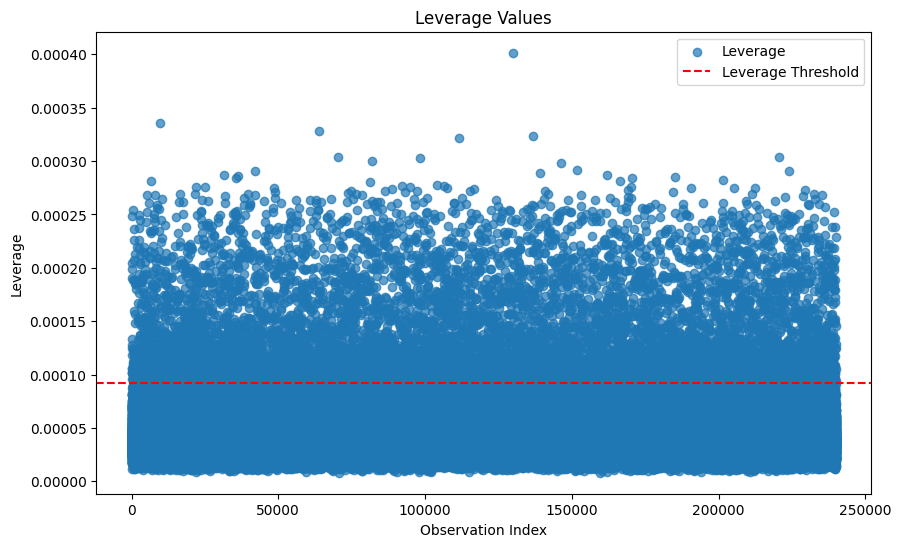

c:\Users\krful\Documents\Code Repo\insurance_ML_pipeline\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


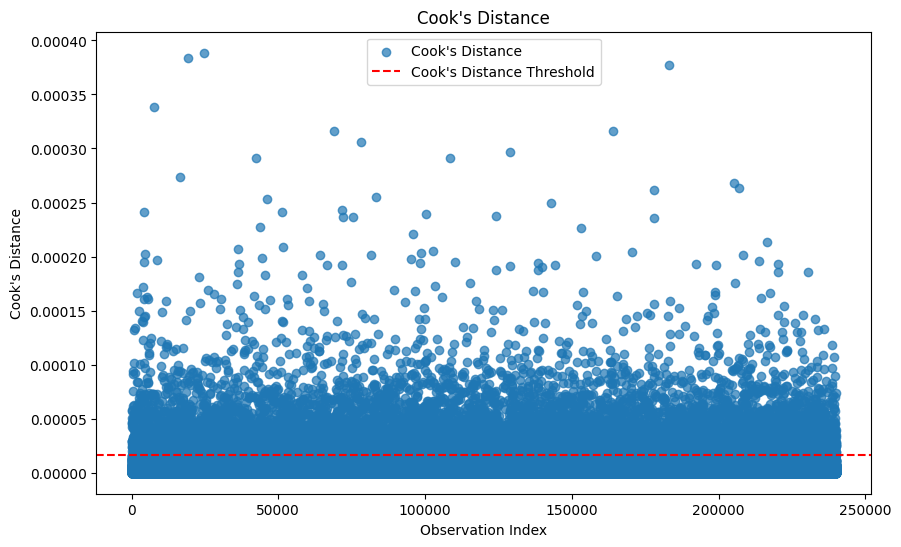

In [11]:
# ensure X_val is numeric and free of missing values
X_val_numeric = X_val.select_dtypes(include=[np.number]).copy()
X_val_numeric = X_val_numeric.fillna(0)

# ensure y_val is numeric and free of missing values
y_val_numeric = y_val.fillna(0)

# add a constant to the features for statsmodels
X_val_with_const = sm.add_constant(X_val_numeric)

# fit an OLS
ols_model = sm.OLS(y_val_numeric, X_val_with_const).fit()

# get influence measures
influence = ols_model.get_influence()

# leverage values
leverage = influence.hat_matrix_diag

# Cook's distance
cooks_d = influence.cooks_distance[0]

# thresholds for high leverage and influential points
leverage_threshold = 2 * (X_val_with_const.shape[1] / X_val_with_const.shape[0])
cooks_d_threshold = 4 / X_val_with_const.shape[0]

# identify high-leverage points
high_leverage_points = np.where(leverage > leverage_threshold)[0]
print(f"Number of high-leverage points: {len(high_leverage_points)}")
print(f"High-leverage points indices: {high_leverage_points}")

# identify influential points
influential_points = np.where(cooks_d > cooks_d_threshold)[0]
print(f"Number of influential points: {len(influential_points)}")
print(f"Influential points indices: {influential_points}")


plt.figure(figsize=(10, 6))
plt.scatter(range(len(leverage)), leverage, label="Leverage", alpha=0.7)
plt.axhline(leverage_threshold, color='red', linestyle='--', label="Leverage Threshold")
plt.xlabel("Observation Index")
plt.ylabel("Leverage")
plt.title("Leverage Values")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(cooks_d)), cooks_d, label="Cook's Distance", alpha=0.7)
plt.axhline(cooks_d_threshold, color='red', linestyle='--', label="Cook's Distance Threshold")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.legend()
plt.show()


## Calculating Feature Importance for XGBoost

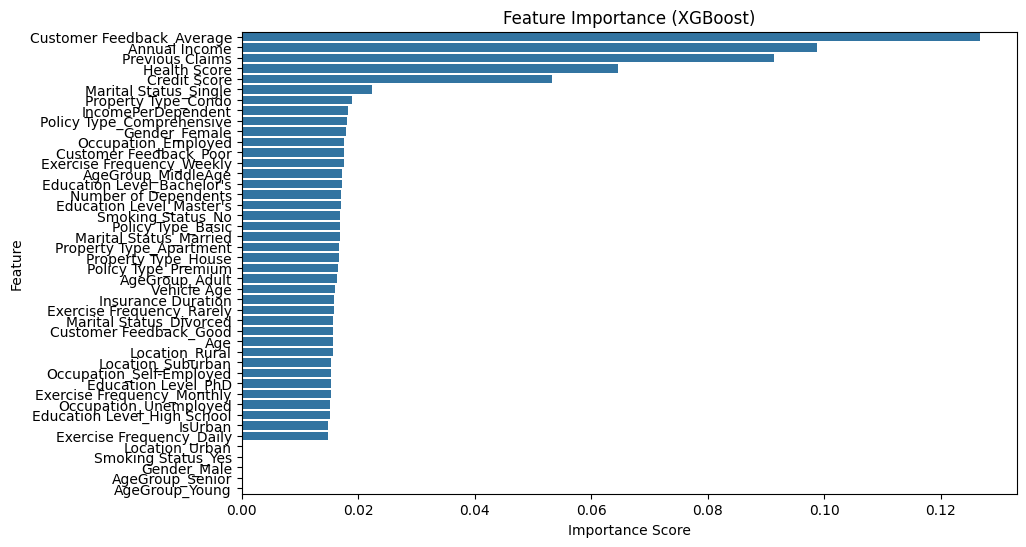

In [12]:
# train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])
xgb_pipeline.fit(X_train, y_train)

# extract feature importance
feature_importance = xgb_model.feature_importances_
feature_names = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][1].get_feature_names_out(cat_cols).tolist()

# create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## SHAP for Feature Importance

In [ ]:
# preprocess the training and validation data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

# convert preprocessed data to a DataFrame for SHAP compatibility
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(cat_cols))
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=feature_names)

# initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_preprocessed)
shap_values = explainer(X_val_preprocessed)

100%|===================| 239929/240000 [24:27<00:00]        

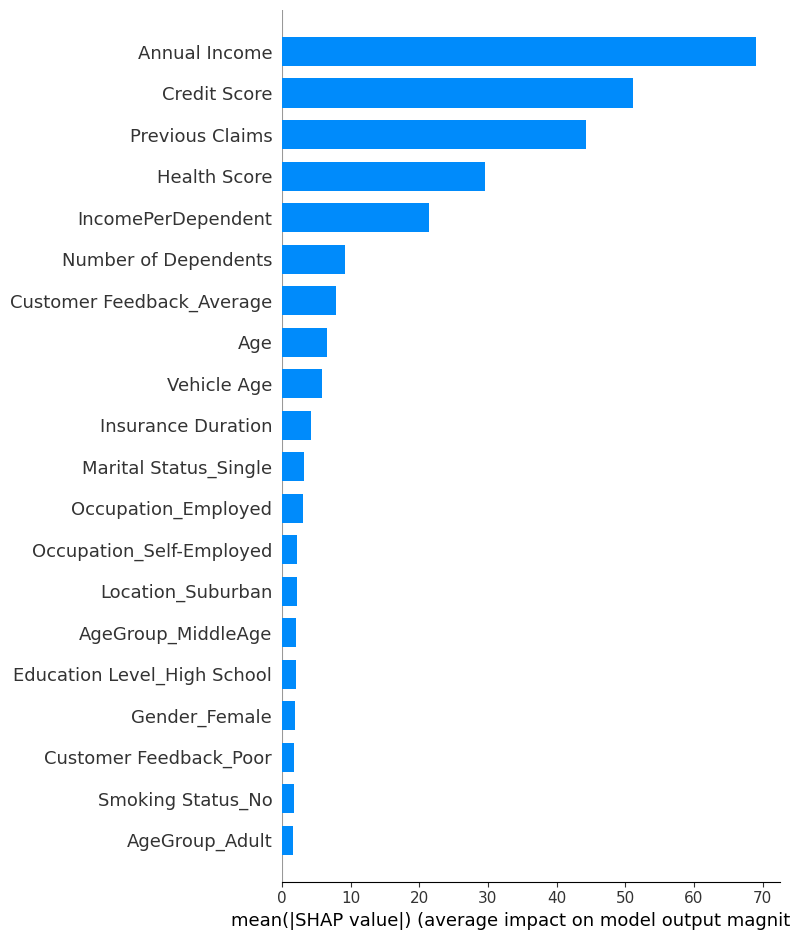

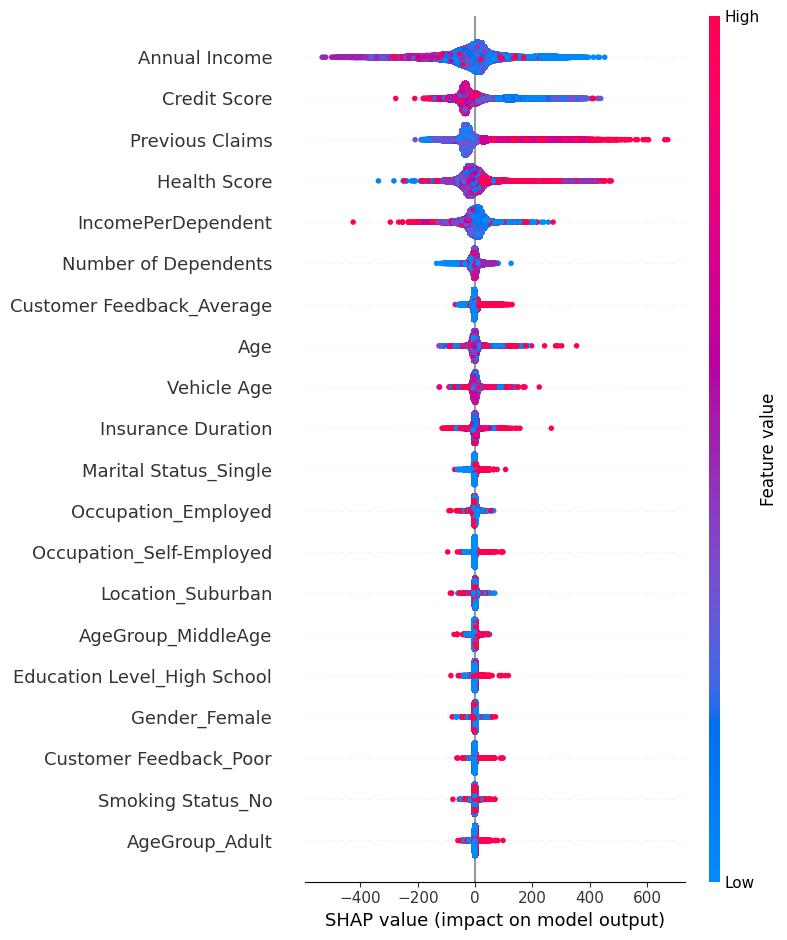

In [ ]:
# SHAP summary plot
shap.summary_plot(shap_values, X_val_preprocessed, plot_type="bar")

# SHAP summary plot with deatiled feature importance
shap.summary_plot(shap_values, X_val_preprocessed)